### Prepare basin DEM inputs for discretization process ###

#### This script requires that the target basin GRU and flowline shapefiles exist ####
If they do not, run 'prepare_basin_shapefiles' script first. <br>

Script tasks (each executed only if needed):
1. project larger full-domain DEM raster into a specified projection system
2. extract DEM for the basin area<br>
3. rasterize basin GRU shapefile based on basin DEM raster
4. calculate slope and aspect for the basin area
5. visualize (plot) slope and aspect results

In [1]:
# import libraries
import os, sys 
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.warp import Resampling
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('../')   # libraries from this repo
import functions.utils as ut
import functions.geospatial_analysis as ga
import functions.geospatial_plot as gp

#### set data paths, filenames, and other settings ####

In [3]:
# common paths
control_file    = '../../control/control.txt.tuolumne'
basin_data_path = ut.read_from_control(control_file, 'basin_data_path')
basin_name      = ut.read_from_control(control_file, 'basin_name')

In [5]:
# large-domain data files
fulldom_dem_raster  = ut.read_from_control(control_file, 'fulldom_dem_raster')

# basin-specific files
basin_gru_shp         = ut.set_filename(control_file, 'basin_gru_shp')
basin_dem_raster      = ut.set_filename(control_file, 'basin_dem_raster')  
basin_slope_raster    = ut.set_filename(control_file, 'basin_slope_raster')  
basin_aspect_raster   = ut.set_filename(control_file, 'basin_aspect_raster') 
basin_flowlines_shp   = ut.set_filename(control_file, 'basin_flowlines_shp')
basin_gru_raster      = ut.set_filename(control_file, 'basin_gru_raster')
refraster             = ut.set_filename(control_file, 'refraster')

# variable / field information
gru_fieldname         = ut.read_from_control(control_file, 'gru_fieldname')      
gruNo_fieldname       = ut.read_from_control(control_file, 'gruNo_fieldname')
gruNo_field_dtype     = ut.read_from_control(control_file, 'gruNo_field_dtype')
gruId_fieldname       = ut.read_from_control(control_file, 'gruId_fieldname')
basin_gruNo_gruId_txt = ut.set_filename(control_file, 'basin_gruNo_gruId_txt')

# derived filenames
dem_prj_raster        = fulldom_dem_raster.split('.tif')[0]+'_prj.tif'
basin_gru_prj_shp     = basin_gru_shp.split('.shp')[0]+'_prj.shp' 

In [6]:
# define equal area projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [9]:
# check whether required input shapefiles exist -- if not, exit
if not (os.path.exists(basin_flowlines_shp) and os.path.exists(basin_gru_prj_shp)):
    print('Required input shapefiles do not exist:', basin_gru_prj_shp, 'and', basin_flowlines_shp )
    print('Run prepare_basin_shapefiles script to create them')
    print('STOP')        # warning in jupyter notebook; use exit() in normal script

#### Extract basin DEM ####

In [10]:
if not os.path.exists(basin_dem_raster):
    if not os.path.exists(dem_prj_raster):
        # reproject large-domain DEM to equal-area projection if it doesn't already exist (can take time (minutes) if the DEM is large)
        ga.reproject_raster(dem_raster, dem_prj_raster, dest_crs, Resampling.bilinear)    # cannot use 'nearest' - results in striations
        print("re-projected full domain raster ( epsg =", new_epsg, "): ", dem_prj_raster)    
    
    ga.crop_raster(dem_prj_raster, basin_gru_prj_shp, basin_dem_raster)
print('basin DEM raster: ', basin_dem_raster)

basin DEM raster:  /glade/work/andywood/complexity/basins/smada/tuolumne/gis/dem.tif


#### Rasterize basin GRU shapefile based on domain DEM raster ####
The basin GRU raster will be used in HRU generation and for calculating zonal statistics

In [12]:
if not (os.path.exists(basin_gru_raster) and os.path.exists(basin_gruNo_gruId_txt)):
    ga.rasterize_gru_vector(basin_gru_prj_shp, gru_fieldname, gruId_fieldname, gruNo_fieldname, gruNo_field_dtype,
                         refraster, basin_gru_raster, basin_gruNo_gruId_txt)
print('rasterized GRU shapefile: ', basin_gru_raster)
print('wrote gruNo to gruId file: ', basin_gruNo_gruId_txt)

rasterized GRU shapefile:  /glade/work/andywood/complexity/basins/smada/tuolumne/gis/gru.tif
wrote gruNo to gruId file:  /glade/work/andywood/complexity/basins/smada/tuolumne/gruNo_gruID.txt


#### Calculate domain slope and aspect, and classify aspect into 8 directions ####

In [13]:
# use numpy module (takes a little while - can skip if these rasters exist)
if not (os.path.exists(basin_slope_raster) and os.path.exists(basin_aspect_raster)):
    ga.calculate_slope_and_aspect(basin_dem_raster, basin_slope_raster, basin_aspect_raster)

    # alternate method: use gdal module
    # from osgeo import gdal
    # gdal.UseExceptions()
    # gdal.DEMProcessing(basin_slope_raster, basin_dem_raster, 'slope', computeEdges=True)
    # gdal.DEMProcessing(basin_aspect_raster, basin_dem_raster, 'aspect', zeroForFlat=True)

basin slope/aspect rasters:  /glade/work/andywood/complexity/basins/smada/tuolumne/gis/slope.tif /glade/work/andywood/complexity/basins/smada/tuolumne/gis/aspect.tif


#### Visualization:  Check slope and aspect results ####

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

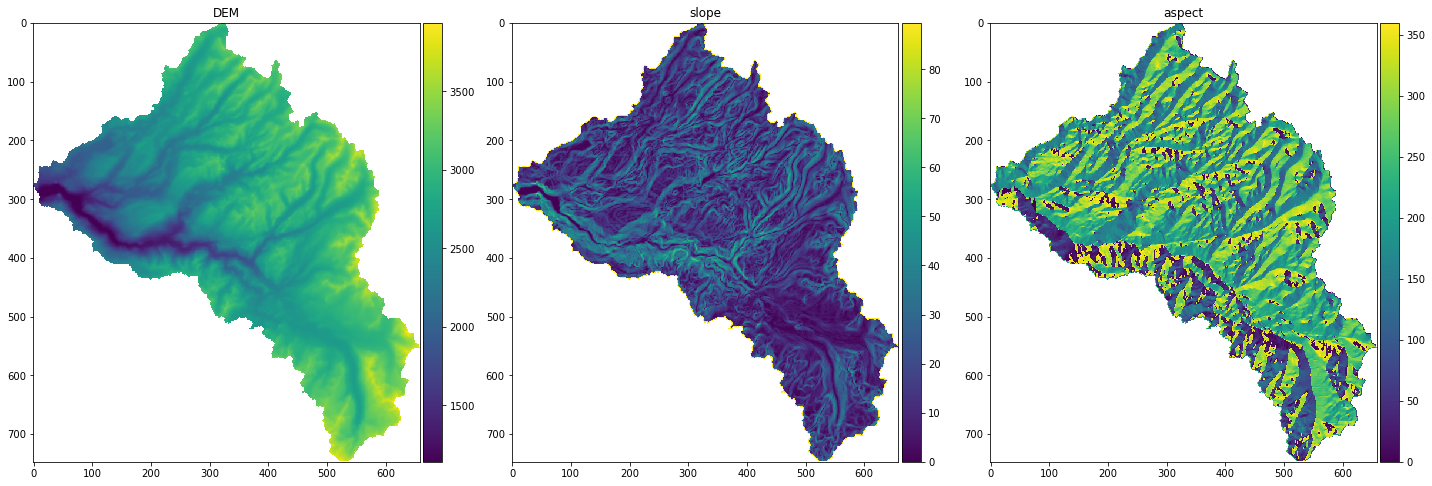

In [14]:
def read_raster(file):   
    with rio.open(file) as ff:
        data = ff.read(1)
        mask = ff.read_masks(1)
    data_ma = np.ma.masked_array(data, mask==0)
    return data_ma

def plot_locatable_axes(data, ax):
    # reference: https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data)
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()

plt.clf()
plt.figure()
f, ax = plt.subplots(1,3, figsize=(20,20)) 

dem_ma = read_raster(basin_dem_raster)
plot_locatable_axes(dem_ma, ax[0])
ax[0].set_title('DEM')

slp_ma = read_raster(basin_slope_raster)
plot_locatable_axes(slp_ma, ax[1])
ax[1].set_title('slope')

asp_ma = read_raster(basin_aspect_raster)
plot_locatable_axes(asp_ma, ax[2])
ax[2].set_title('aspect')

plt.tight_layout()
plt.show()

#### Done prepping DEM grids ####

#### Optional visualization: aspect 8-cateory class ####

In [ ]:
# classify aspect into 8 classes (can skip if this exists) -- this can also be done in 'analysis' phase
aspect_class_raster = basin_aspect_raster.split('.tif')[0]+'_class.tif'
if not os.path.exists(aspect_class_raster):
    ga.classify_aspect(basin_aspect_raster, 8, aspect_class_raster)
    
print('basin slope/aspect rasters: ', basin_slope_raster, basin_aspect_raster)

data_unique: [0 1 2 3 4 5 6 7 8]
data_counts: [  274 22031 13246 14646 28132 26128 24088 28337 33541]
length data_unique: 9
legend_labels: {0: ['black', 'Flat (0)'], 1: ['red', 'North (337.5 - 22.5)'], 2: ['orange', 'Northeast (22.5 - 67.5)'], 3: ['yellow', 'East (67.5 - 112.5)'], 4: ['lime', 'Southeast (112.5 - 157.5)'], 5: ['cyan', 'South (157.5 - 202.5)'], 6: ['cornflowerblue', 'Southwest (202.5 - 247.5)'], 7: ['blue', 'West (247.5 - 292.5)'], 8: ['purple', 'Northwest (292.5 - 337.5)']}


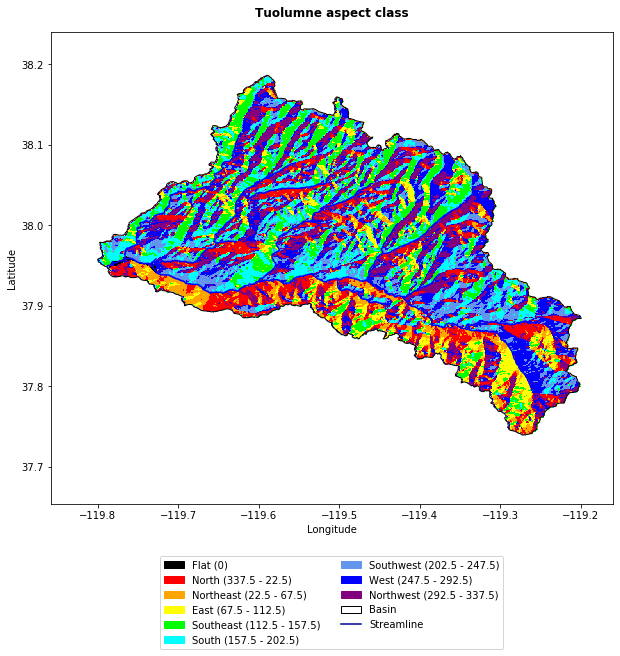

In [15]:
# define legend dictionary. dist[raster_value]=list(color,label)
legend_dict = {0:["black", "Flat (0)"],
               1:["red", "North (337.5 - 22.5)"],
               2:["orange", 'Northeast (22.5 - 67.5)'],
               3:["yellow", 'East (67.5 - 112.5)'], 
               4:["lime", 'Southeast (112.5 - 157.5)'], 
               5:["cyan", 'South (157.5 - 202.5)'], 
               6:["cornflowerblue", 'Southwest (202.5 - 247.5)'], 
               7:["blue", 'West (247.5 - 292.5)'], 
               8:["purple", 'Northwest (292.5 - 337.5)']} 

label_dict =  {0:"Flat (0)",
               1:"North (337.7 - 22.5)",
               2:'Northeast (22.5 - 67.5)',
               3:'East (67.5 - 112.5)', 
               4:'Southeast (112.5 - 157.5)', 
               5:'South (157.5 - 202.5)', 
               6:'Southwest (202.5 - 247.5)', 
               7:'West (247.5 - 292.5)', 
               8:'Northwest (292.5 - 337.5)'}

wgs_epsg = 4326
figsize  = (15,15*0.6) # width, height in inches
title    = basin_name.capitalize() + ' aspect class'
leg_ncol = 2
leg_loc  = 'upper center'
leg_bbox_to_anchor = (0.5,-0.1)

# plot classified aspect
output_fig_file = os.path.join(basin_data_path, 'plots/aspect_class_and_bound_stream.png')   
gp.plot_raster_and_bound_stream(aspect_class_raster, basin_gru_prj_shp, basin_flowlines_shp, wgs_epsg, 'user', legend_dict, figsize, title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)